In [ ]:
## imports
# read
# drop arival rate of delayed flights
# make the barrier or threshold for classification
# break up into num and cat 
# x and target y as delay rate 
# scale encode and transform
# make knn filter 5 and weight as distance
# make pipeline
# fit the model on training data
# predict and confusion matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_score,
    precision_recall_curve
)


In [ ]:
df = pd.read_csv("Airline_Delay_Cause.csv") # Read data
df.info()
df.head()

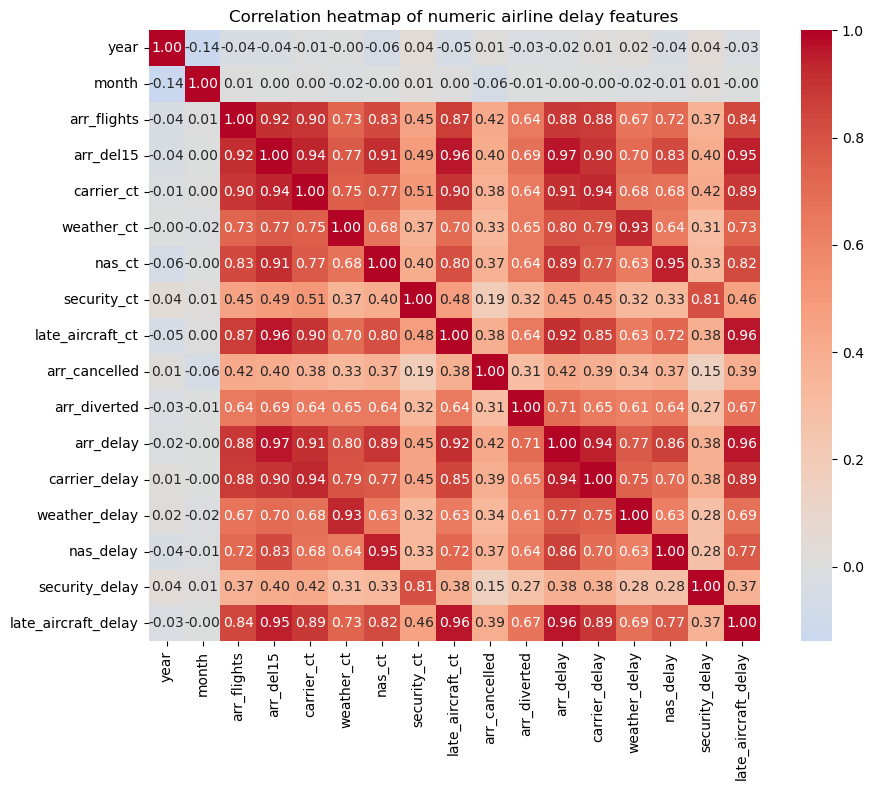

In [ ]:
num_cols = df.select_dtypes(include=["number"])
corr = num_cols.corr()

# heat map of all features
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,          # show numbers
    fmt=".2f",           # 2 decimal places
    center=0,
    square=True
)
plt.title("Correlation heatmap of numeric airline delay features")
plt.tight_layout()
plt.show()

In [ ]:
df = df.dropna(subset=["arr_flights", "arr_del15"]) # drop features to get the delay rate

In [ ]:
# calculate the delay rate if less than 20% 0 and if greater that 20% it is 1
df["arr_delay_rate"] = df["arr_del15"] / df["arr_flights"]
df["delay_15_label"] = (df["arr_delay_rate"] >= 0.20).astype(int)


In [ ]:
# select features that pass leak test
feature_cols_num = ["year", "month", "arr_flights", "arr_cancelled", "arr_diverted"]
feature_cols_cat = ["carrier", "carrier_name", "airport"]


In [ ]:
# x and target set
X = df[feature_cols_num + feature_cols_cat]
y = df["delay_15_label"]

In [ ]:
# scale encode and transform 
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

In [ ]:
# make the KNN classifier model 
knn = KNeighborsClassifier(n_neighbors=7, weights="distance") # determines high low off 5 closest points 

In [ ]:
# # Model with neighbours set to 10 test
# knn = KNeighborsClassifier(n_neighbors=10, weights="distance") 

In [ ]:
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("knn", knn),
])

In [ ]:
start_knn = time.time()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
y_pred = clf.predict(X_test)
end_knn = time.time()
time_knn = end_knn - start_knn

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month',
                                                   'arr_flights',
                                                   'arr_cancelled',
                                                   'arr_diverted']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['carrier', 'carrier_name',
                                                   'airport'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])

Training + prediction time (s): 0.0824
[[25478  5819]
 [ 9076 10994]]
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     31297
           1       0.65      0.55      0.60     20070

    accuracy                           0.71     51367
   macro avg       0.70      0.68      0.68     51367
weighted avg       0.70      0.71      0.70     51367



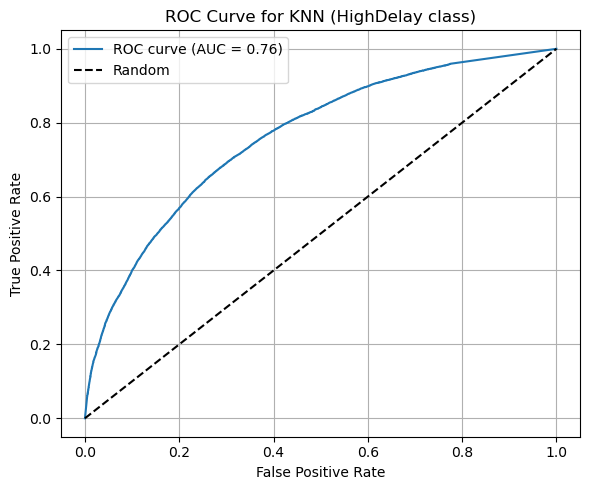

In [30]:
print("Training + prediction time (s): %.4f" % time_knn)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



# roc and auc graph
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for KNN (HighDelay class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

results = []

for k in [5, 6, 7, 8, 9]:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn_clf_k = Pipeline(steps=[
        ("preprocess", preprocess),
        ("knn", knn),
    ])
    knn_clf_k.fit(X_train, y_train)
    y_pred_k = knn_clf_k.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    
    # focus on HighDelay (class 1) precision/recall/F1
    report = classification_report(y_test, y_pred_k, output_dict=True)
    prec1 = report["1"]["precision"]
    rec1 = report["1"]["recall"]
    f11 = report["1"]["f1-score"]
    
    results.append({
        "k": k,
        "accuracy": acc,
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f11,
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


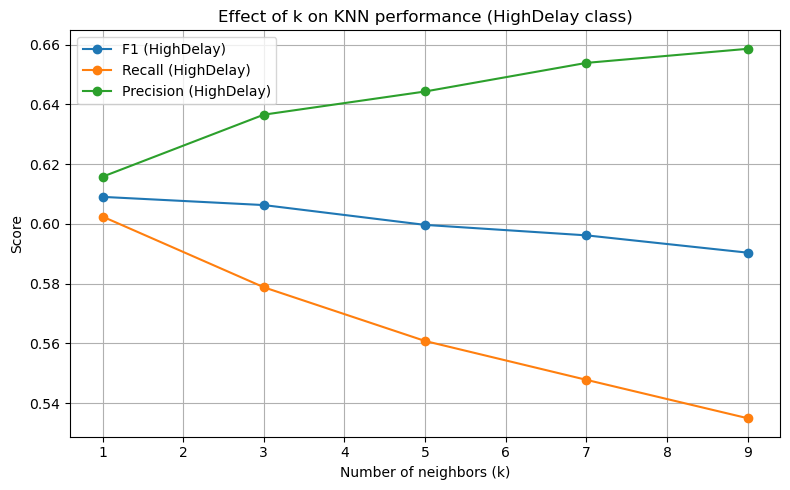

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(results_df["k"], results_df["f1_1"], marker="o", label="F1 (HighDelay)")
plt.plot(results_df["k"], results_df["recall_1"], marker="o", label="Recall (HighDelay)")
plt.plot(results_df["k"], results_df["precision_1"], marker="o", label="Precision (HighDelay)")

plt.xlabel("Number of neighbors (k)")
plt.ylabel("Score")
plt.title("Effect of k on KNN performance (HighDelay class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

